In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams['hatch.linewidth'] = 2
plt.rcParams["mathtext.fontset"] = "dejavuserif"

dataset = ["STK","TAO","HPC","GAS","EM","FC"]
dataset_small = ["STK","GAS","EM"]

alg_name = "MDUAL"

algo_color = {'NAIVE': 'grey',
              'SOP': '#4BACC6',
              'pMCSKY': '#1F497D',
              alg_name+'-Q': '#ffb836',
              alg_name+'-D': '#ff7c36',
              alg_name: '#C0504D'}

algo_hatch = {'NAIVE': '|||',
              'SOP': '++',
              'pMCSKY': 'xx',
              alg_name+'-Q': '--',
              alg_name+'-D': '//',
              alg_name: '\\\\\\\\'}

algo_line = {'NAIVE': '-',
              'SOP': '--',
              'pMCSKY': '-.',
              alg_name+'-Q': '--',
              alg_name+'-D': '--',
              alg_name: '-'}

algo_marker = {'NAIVE': '',
              'SOP': 's',
              'pMCSKY': '^',
              alg_name+'-Q': 'x',
              alg_name+'-D': 'x',
              alg_name: 'x'}


basic_linewidth = 3
algo_linewidth = {'NAIVE': basic_linewidth/2,
                  'SOP': basic_linewidth/2,
                  'pMCSKY': basic_linewidth/2,
                  alg_name+'-Q': basic_linewidth/2,
                  alg_name+'-D': basic_linewidth/2,
                  alg_name: basic_linewidth}

# Overall Bar Plot Parameters
# overall figure width in latex: 0.49
barWidth = 0.75
FONTSIZE_XTICK=18
FONTSIZE_YTICK=18
FONTSIZE_XLABEL=20
FONTSIZE_YLABEL=20
intra_bar_space = 1.2
inter_bar_space = 2
figsize_overall=(10,3)
target_alg_others = ['SOP','pMCSKY',alg_name]
target_alg_ours = [alg_name+'-Q',alg_name+'-D',alg_name]
# Line Plot parameters
figsize_q = (3,3)
target_alg_q = ['SOP','pMCSKY',alg_name]
FONTSIZE_XTICK_q=18
FONTSIZE_YTICK_q=18
FONTSIZE_XLABEL_q=20
FONTSIZE_YLABEL_q=20


figsize_stationarity = (3,3)
target_alg_stationarity = ['SOP','pMCSKY',alg_name]
FONTSIZE_XTICK_stationarity=18
FONTSIZE_YTICK_stationarity=18
FONTSIZE_XLABEL_stationarity=20
FONTSIZE_YLABEL_stationarity=20

figsize_vp = (1.5,2)
target_alg_vp = ['SOP','pMCSKY',alg_name]
FONTSIZE_XTICK_vp=13
FONTSIZE_YTICK_vp=13
FONTSIZE_XLABEL_vp=12
FONTSIZE_YLABEL_vp=12
barWidth_vp = 0.5
intra_bar_space_vp = 0.82
inter_bar_space_vp = 1.5


figsize_cx = (10,1.5)
FONTSIZE_XTICK_cx=18
FONTSIZE_YTICK_cx=18
FONTSIZE_XLABEL_cx=20
FONTSIZE_YLABEL_cx=20
barWidth_cx = 0.5
intra_bar_space_cx = 0.82
inter_bar_space_cx = 1.5

In [2]:
fileList = ['result_default_numQuery','result_varyingParams','result_varyingStatRatio','result_varingGrouping_STK_TAO_HPC','result_varingGrouping_GAS_EM_FC']

def preprocessing(path):
    headerf = open("Data/"+path+".txt")
    header = headerf.readline()
    header = "\t".join(header.split())
    w=open(os.getcwd()+"/Metadata/"+path+"_separated.csv",'w')
    w.write(header+"\n")

    f=open("Data/"+path+".txt",'r')
    i = -1
    for line in f.readlines():
        i += 1
        if (len(line.split())<9) or (i<1):
            continue
        line = line.replace("OURS",alg_name)
        tab_sep_line = "\t".join(line.split())
        w.write(tab_sep_line+"\n")
    w.close()
    dataframe = pd.read_csv(os.getcwd()+"/Metadata/"+path+"_separated.csv", sep="\t")

    #averaging all trials
    dataframe = dataframe.groupby(["Dataset","Queryset","ChgQRatio","Method"]).mean()
    dataframe.reset_index(inplace=True)
    return dataframe   

def preprocessing_params(path):
    headerf = open("Data/"+path+".txt")
    header = headerf.readline()
    header = "\t".join(header.split())
    w=open(os.getcwd()+"/Metadata/"+path+"_separated.csv",'w')
    w.write(header+"\tparamKey"+"\n")

    f=open("Data/"+path+".txt",'r')
    i = -1
    for line in f.readlines():
        i += 1
        if (i<2):
            continue
        if 'Varying R' in line:
            param_key = "R"
            continue
        elif 'Varying K' in line:
            param_key = "K"
            continue
        elif 'Varying W' in line:
            param_key = "W"
            continue
        elif 'Varying S' in line:
            param_key = "S"
            continue
        line = line.replace("OURS",alg_name)
        line += "\t" + param_key
        tab_sep_line = "\t".join(line.split())
        w.write(tab_sep_line+"\n")
    w.close()
    dataframe = pd.read_csv(os.getcwd()+"/Metadata/"+path+"_separated.csv", sep="\t")
    dataframe = dataframe.groupby(["Dataset","Queryset","ChgQRatio","Method","paramKey"]).mean()
    dataframe.reset_index(inplace=True)
    return dataframe


In [5]:
def bargraph(df, dataset, metric, prefix, FONTSIZE_XLABEL, FONTSIZE_YLABEL, FONTSIZE_XTICK, FONTSIZE_YTICK, ytickList):
    dataset_ = dataset.copy()
    dataname = dataset_.pop()

    graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values=metric)
    for dataname in dataset_:
        graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time")])

    graphdf = graphdf[target_alg_others]
    graphdf = graphdf.reindex(index=dataset)
    fig = plt.figure(figsize=figsize_overall)
    ax = fig.add_subplot(1,1,1)
    xpositions = []
    for i, algname in enumerate(target_alg_others):
        xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_others) + inter_bar_space) + barWidth*intra_bar_space*i
        xpositions.append(xposition)
        ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
               linewidth=algo_linewidth[algname], zorder=2)
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_yscale("log")
    ax.set_xlabel("Datasets", fontsize=FONTSIZE_XLABEL)
    if metric=="Time":
        ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL)
    else:
        ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL)

    ax.set_xlim([-barWidth,xposition[-1]+barWidth])
    ax.set_ylim([ytickList[0], ytickList[-1]])
    plt.yticks(ytickList)
    if metric!="Time":
        ax.set_yticklabels(list(map(str, ytickList)))
    xpositions=np.array(xpositions)
    xcenter = np.mean(xpositions,axis=0)
    plt.xticks(xcenter,dataset)
    for i in range(len(xcenter)-1):
        plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)
    # remove ticks
    ax.tick_params(axis ='both', which ='both', length = 0)
    ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK)
    ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
    # rotate ticks
    ax.tick_params(axis ='x', rotation = 0)
    if metric=="Time":
        plt.savefig("Figures/"+prefix+'_CpuTime.pdf', bbox_inches='tight', format='pdf')
    else:
        plt.savefig("Figures/"+prefix+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

In [6]:
def bargraph_Params(df, dataset, metric, FONTSIZE_XLABEL, FONTSIZE_YLABEL, FONTSIZE_XTICK, FONTSIZE_YTICK, ytickList):
    plt.rcParams['hatch.linewidth'] = 2
    for vp in ["R","K","W","S"]:
        dataset_ = dataset.copy()
        dataname = dataset_.pop()
        graphdf = df.loc[(df["Dataset"]==dataname) & (df['paramKey']==vp)].pivot(index="Dataset",columns="Method",values=metric)
        for dataname in dataset_:
            graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname) & (df['paramKey']==vp)].pivot(index="Dataset",columns="Method",values=metric)])
        graphdf = graphdf[target_alg_vp]
        graphdf = graphdf.reindex(index=dataset)
        fig = plt.figure(figsize=figsize_vp)
        ax = fig.add_subplot(1,1,1)
        xpositions = []
        for i, algname in enumerate(target_alg_vp):
            xposition = np.arange(graphdf.shape[0])*barWidth_vp*(len(target_alg_vp) + inter_bar_space_vp) + barWidth*intra_bar_space_vp*i
            xpositions.append(xposition)
            ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth_vp,\
                   hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
                   linewidth=algo_linewidth[algname], zorder=2)
        ax.grid(b=True,which="major",axis='y',zorder=0)
        ax.set_yscale("log")
        ax.set_xlabel("Datasets", fontsize=FONTSIZE_XLABEL)
        if metric=="Time":
            ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL)
        else:
            ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL)

        ax.set_xlim([-barWidth_vp,xposition[-1]+barWidth_vp])
        ax.set_ylim([ytickList[0], ytickList[-1]])
        plt.yticks(ytickList)
        if metric!="Time":
            ax.set_yticklabels(list(map(str, ytickList)))
        xpositions=np.array(xpositions)
        xcenter = np.mean(xpositions,axis=0)
        plt.xticks(xcenter,dataset)
        for i in range(len(xcenter)-1):
            plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)
        # remove ticks
        ax.tick_params(axis ='both', which ='both', length = 0)
        ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK)
        ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
        # rotate ticks
        ax.tick_params(axis ='x', rotation = 0)
        if metric=="Time":
            plt.savefig("Figures/"+'VaryingParam_'+vp+'_CpuTime.pdf', bbox_inches='tight', format='pdf')
        else:
            plt.savefig("Figures/"+'VaryingParam_'+vp+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

# Overall Performance
###### queryNumber=100, ChgQRatio>0, targetAlgorithm = SOP, pMCSKY, OURS

In [5]:
# df = preprocessing("result_default_numQuery")
# bargraph(df=df, dataset=dataset, metric="Time", prefix="Overall", \
#         FONTSIZE_XLABEL=FONTSIZE_XLABEL, FONTSIZE_YLABEL=FONTSIZE_YLABEL,\
#         FONTSIZE_TICK=FONTSIZE_TICK, ytickList=[1e1,1e3,1e5])
#
#
# bargraph(df=df, dataset=dataset, metric="PeakMem", prefix="Overall",\
#         FONTSIZE_XLABEL=FONTSIZE_XLABEL, FONTSIZE_YLABEL=FONTSIZE_YLABEL,\
#         FONTSIZE_TICK=FONTSIZE_TICK, ytickList=[1,32,1024])

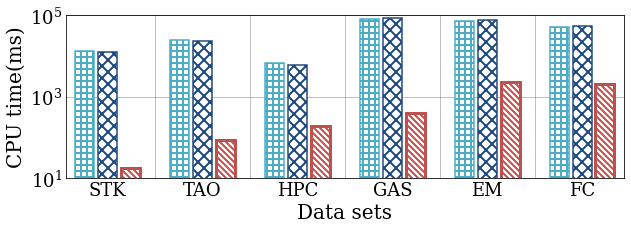

In [6]:
# df1 = preprocessing("STK")
# df2 = preprocessing("TAO")
# df3 = preprocessing("GAS")
# df4 = preprocessing("HPC")
# df5 = preprocessing("EM")
# df6 = preprocessing("FC")
# df = pd.concat([df1,df2,df3,df4,df5,df6])
df = preprocessing("result_varyingGrouping")

df.to_excel(os.getcwd()+"/Metadata/result_varyingGrouping.xlsx")


dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="Time")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time")])

graphdf = graphdf[target_alg_others]


graphdf = graphdf.reindex(index=dataset)
fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_others):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_others)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL)
ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL)

ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([10,100000])
plt.yticks([10,1e3,1e5])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)


# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK) # pad=15
ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig("Figures/"+'Overall_CpuTime.pdf', bbox_inches='tight', format='pdf')


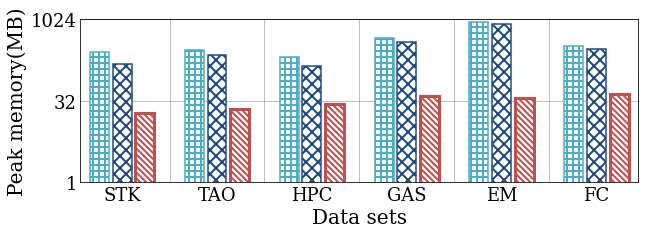

In [7]:
df = preprocessing("result_varyingGrouping")

dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem")])

graphdf = graphdf[target_alg_others]

graphdf = graphdf.reindex(index=dataset)
fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_others):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_others)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log",basey=2)
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL)
ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL)
ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([1,1024])
plt.yticks([1,32,1024])
ax.set_yticklabels(['1','32','1024'])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)

# remove ticks
ax.tick_params(axis='both', which ='both', length = 0)
ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK)
ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)

plt.savefig("Figures/"+'Overall_PeakMem.pdf', bbox_inches='tight', format='pdf')

#### Overall Legend

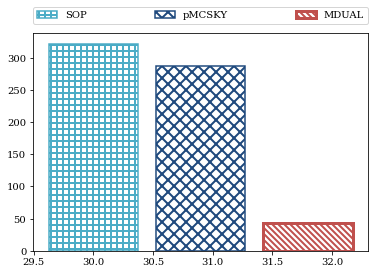

In [8]:
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="PeakMem")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                                         & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="PeakMem")])
graphdf = graphdf[target_alg_others]

graphdf = graphdf.reindex(index=dataset)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i, algname in enumerate(target_alg_others):
    xposition = np.arange(graphdf.shape[0])*barWidth*(graphdf.shape[0]+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
               linewidth=algo_linewidth[algname], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=target_alg_others,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_others), mode="expand", borderaxespad=0.)

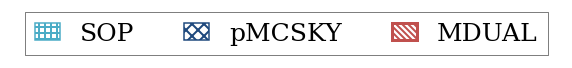

In [9]:
figsize = (10, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
legend = ax_leg.legend(handles=bars,labels=target_alg_others, loc='center', ncol=len(target_alg_others), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =1,\
              prop={'size':25}
              )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
legend.get_frame().set_linewidth(0.5)
fig_leg.savefig("Figures/"+'Overall_Legend.pdf', bbox_inches='tight', format='pdf')

# ax_leg.legend(handles=bars,labels=cx_params_space, loc='center', ncol=len(cx_params_space), \
#                 facecolor='white', framealpha=1, edgecolor='black', fancybox = False, handlelength =1,\
#               prop={'size':20}
#               )

# Varying grouping

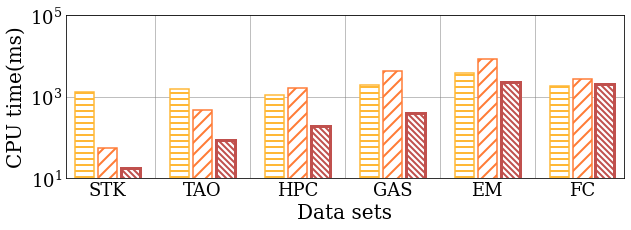

In [10]:
df = preprocessing("result_varyingGrouping")

df.to_excel(os.getcwd()+"/Metadata/result_varyingGrouping.xlsx")


dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="Time")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time")])

graphdf = graphdf[target_alg_ours]


graphdf = graphdf.reindex(index=dataset)
fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_ours):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_ours)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL)
ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL)

ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([10,100000])
plt.yticks([10,1e3,1e5])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)


# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK) # pad=15
ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig("Figures/"+'Grouping_CpuTime.pdf', bbox_inches='tight', format='pdf')


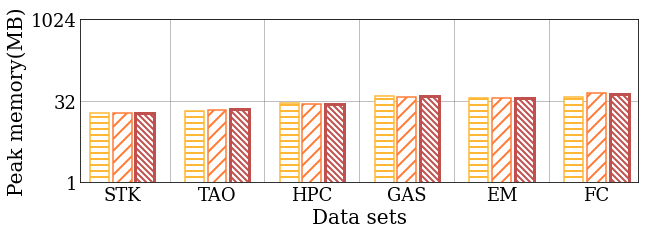

In [11]:
df = preprocessing("result_varyingGrouping")

dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem")])

graphdf = graphdf[target_alg_ours]

graphdf = graphdf.reindex(index=dataset)
fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_ours):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_ours)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log",basey=2)
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL)
ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL)
ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([1,1024])
plt.yticks([1,32,1024])
ax.set_yticklabels(['1','32','1024'])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)

# remove ticks
ax.tick_params(axis='both', which ='both', length = 0)
ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK)
ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)

plt.savefig("Figures/"+'Grouping_PeakMem.pdf', bbox_inches='tight', format='pdf')

#### Grouping Legend

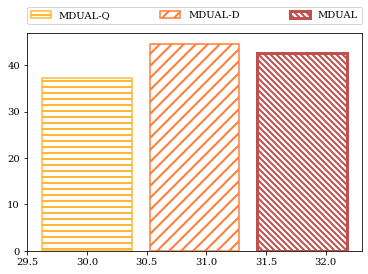

In [12]:
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="PeakMem")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                                         & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="PeakMem")])
graphdf = graphdf[target_alg_ours]

graphdf = graphdf.reindex(index=dataset)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i, algname in enumerate(target_alg_ours):
    xposition = np.arange(graphdf.shape[0])*barWidth*(graphdf.shape[0]+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
               linewidth=algo_linewidth[algname], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=target_alg_ours,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_ours), mode="expand", borderaxespad=0.)

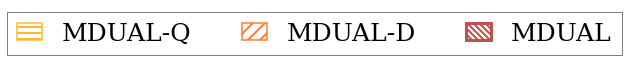

In [13]:
figsize = (10, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
legend = ax_leg.legend(handles=bars,labels=target_alg_ours, loc='center', ncol=len(target_alg_ours), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =1,\
              prop={'size':25}
              )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
legend.get_frame().set_linewidth(0.5)
fig_leg.savefig("Figures/"+'Grouping_Legend.pdf', bbox_inches='tight', format='pdf')

# ax_leg.legend(handles=bars,labels=cx_params_space, loc='center', ncol=len(cx_params_space), \
#                 facecolor='white', framealpha=1, edgecolor='black', fancybox = False, handlelength =1,\
#               prop={'size':20}
#               )

# Changing the number of queries - CPU time, Peak memory
###### ChgQRatio>0, targetAlgorithm = ALL
## CPU time

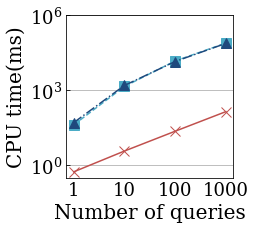

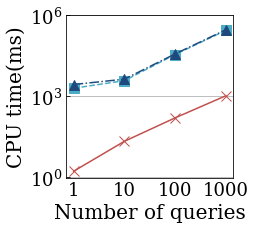

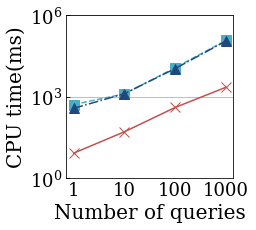

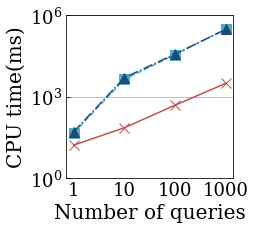

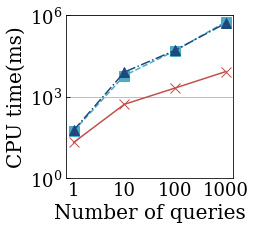

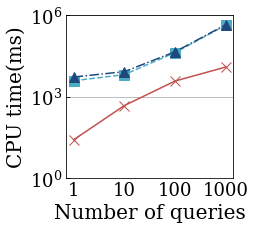

In [14]:
# df1 = preprocessing("STK")
# df2 = preprocessing("TAO")
# df3 = preprocessing("GAS")
# df4 = preprocessing("HPC")
# df5 = preprocessing("EM")
# df6 = preprocessing("FC")
# df = pd.concat([df1,df2,df3,df4,df5,df6])
df = preprocessing("result_default_numQuery")
df.to_excel(os.getcwd()+"/Metadata/result_default_numQuery.xlsx")

for dataname in dataset:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0)]\
        .pivot(index="Queryset",columns="Method",values="Time")

    graphdf.reindex(index=dataset)
    fig = plt.figure(figsize=figsize_q)
    ax = fig.add_subplot(1,1,1)

    for i, algname in enumerate(target_alg_q):
        ax.plot(graphdf[algname], linestyle=algo_line[algname], markersize=10, marker=algo_marker[algname], color=algo_color[algname])
    ax.set_yscale("log")
    ax.set_xlabel("Number of queries", fontsize=FONTSIZE_XLABEL_q)
    ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_q)
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xticklabels([1,10,100,1000])
    ax.tick_params(axis='x', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_q)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_q)
    ax.tick_params(axis='y', which ='minor', length = 0)
    ax.tick_params(axis='y', which ='major', direction='in')
    plt.yticks([1,10**3,10**6])
    plt.savefig("Figures/"+'QueryNum_'+dataname+'_CpuTime.pdf', bbox_inches='tight', format='pdf')

## Peak memory

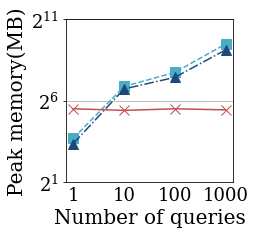

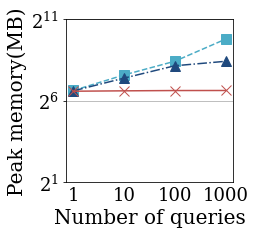

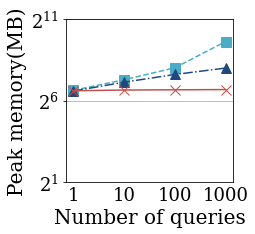

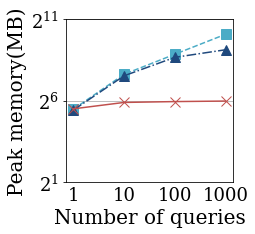

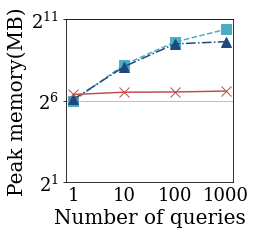

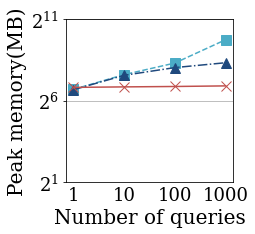

In [15]:
df = preprocessing("result_default_numQuery")
for dataname in dataset:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0)]\
        .pivot(index="Queryset",columns="Method",values="PeakMem")

    graphdf.reindex(index=dataset)

    fig = plt.figure(figsize=figsize_q)
    ax = fig.add_subplot(1,1,1)

    for i, algname in enumerate(target_alg_q):
        ax.plot(graphdf[algname], markersize=10, linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.set_yscale("log",basey=2)
    ax.set_xlabel("Number of queries", fontsize=FONTSIZE_XLABEL_q)
    ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_q)
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xticklabels([1,10,100,1000])
    ax.tick_params(axis='x', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_q)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_q)
    plt.yticks([2,2**6,2**11])
    plt.savefig("Figures/"+'QueryNum_'+dataname+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

# Changing the stationarity of queries - CPU time, Peak memory
###### numQuery=100, targetAlgorithm = ALL

In [16]:
# graphdf_stationary = df.loc[(df['ChgQRatio']==0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time").reindex(dataset)
# graphdf_dynamic = df.loc[(df['ChgQRatio']>0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time").reindex(dataset)
#
# fig = plt.figure(figsize=figsize_vp)
# ax = fig.add_subplot(1,1,1)
# for i, algname in enumerate(target_alg_stationarity):
#     ax.plot(graphdf_stationary[algname], linestyle='--', marker=algo_marker[algname], color=algo_color[algname])
#     ax.plot(graphdf_dynamic[algname], linestyle='-', marker=algo_marker[algname], color=algo_color[algname])
# ax.grid(b=True,which="major",axis='y',zorder=0)
# ax.set_xlabel("")
# ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_stationarity)
#
# ax.tick_params(axis='both', which ='both', length = 0)
# ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_stationarity)
# ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_stationarity)
#
# ax.tick_params(axis ='x', rotation = 0, pad=10)
# plt.savefig('Stationarity_CpuTime.pdf', bbox_inches='tight', format='pdf')
#
# graphdf_stationary = df.loc[(df['ChgQRatio']==0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem").reindex(dataset)
# graphdf_dynamic = df.loc[(df['ChgQRatio']>0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem").reindex(dataset)
#
# fig = plt.figure(figsize=figsize_vp)
# ax = fig.add_subplot(1,1,1)
# for i, algname in enumerate(target_alg_stationarity):
#     ax.plot(graphdf_stationary[algname], linestyle='--', marker=algo_marker[algname], color=algo_color[algname])
#     ax.plot(graphdf_dynamic[algname], linestyle='-', marker=algo_marker[algname], color=algo_color[algname])
# ax.grid(b=True,which="major",axis='y',zorder=0)
# ax.set_xlabel("")
# ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_stationarity)
#
# ax.tick_params(axis='both', which ='both', length = 0)
# ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_stationarity)
# ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_stationarity)
#
# ax.tick_params(axis ='x', rotation = 0, pad=10)
# plt.savefig('Stationarity_PeakMem.pdf', bbox_inches='tight', format='pdf')

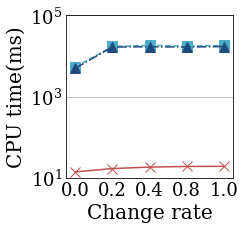

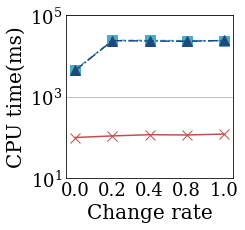

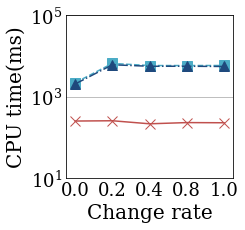

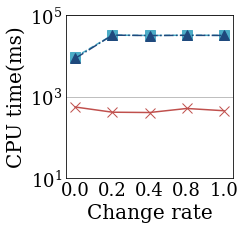

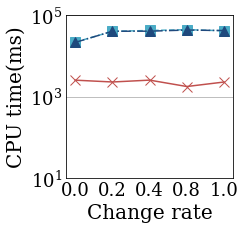

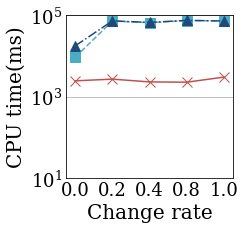

In [17]:
# df1 = preprocessing("STK")
# df2 = preprocessing("TAO")
# df3 = preprocessing("GAS")
# df4 = preprocessing("HPC")
# df5 = preprocessing("EM")
# df6 = preprocessing("FC")
# df = pd.concat([df1,df2,df3,df4,df5,df6])

df = preprocessing("result_varyingChgdQRatio")
df.to_excel(os.getcwd()+"/Metadata/result_varyingChgdQRatio.xlsx")

x = [0,0.2,0.4,0.6,0.8]
for dataname in dataset:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="Time")

    graphdf.index=df["ChgQRatio"].unique()
    graphdf = graphdf[target_alg_stationarity]
    fig = plt.figure(figsize=figsize_stationarity)
    ax = fig.add_subplot(1,1,1)
    for i, algname in enumerate(target_alg_stationarity):
        ax.plot(x, graphdf[algname].tolist(), linestyle=algo_line[algname], markersize=10,marker=algo_marker[algname], color=algo_color[algname])
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xlabel("Change rate", fontsize=FONTSIZE_XLABEL_stationarity)
    ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_stationarity)
    ax.set_xlim([-0.05,0.85])
    ax.set_yscale("log")
    ax.tick_params(axis='both', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_stationarity)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_stationarity)
    plt.xticks([0.0,0.2,0.4,0.6,0.8])
    ax.set_xticklabels([0.0,0.2,0.4,0.8,1.0])
    plt.yticks([1e1,1e3,1e5])
    ax.tick_params(axis ='x', rotation = 0)

    plt.savefig("Figures/"+'Stationarity_'+dataname+'_CpuTime.pdf', bbox_inches='tight', format='pdf')

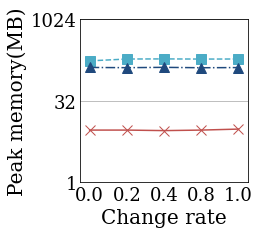

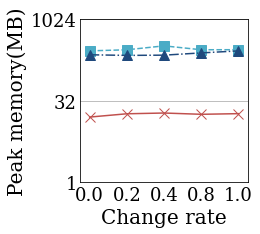

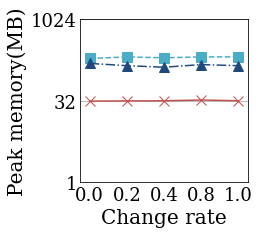

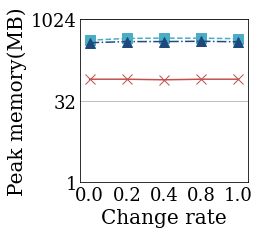

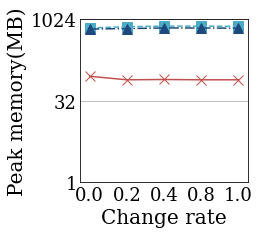

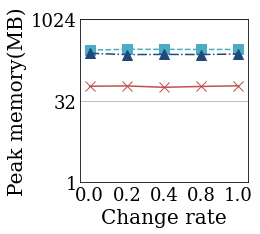

In [38]:
df = preprocessing("result_varyingChgdQRatio")
x = [0,0.2,0.4,0.6,0.8]
for dataname in dataset:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
    graphdf.index=df["ChgQRatio"].unique()
    graphdf = graphdf[target_alg_stationarity]
    fig = plt.figure(figsize=figsize_stationarity)
    ax = fig.add_subplot(1,1,1)
    for i, algname in enumerate(target_alg_stationarity):
        ax.plot(x,graphdf[algname], linestyle=algo_line[algname], markersize=10,marker=algo_marker[algname], color=algo_color[algname])
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xlabel("Change rate", fontsize=FONTSIZE_XLABEL_stationarity)
    ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_stationarity)
    ax.set_xlim([-0.05,0.85])
    ax.set_yscale("log",basey=2)
    ax.tick_params(axis='both', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_stationarity)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_stationarity)

    ax.tick_params(axis ='x', rotation = 0)
    plt.xticks([0.0,0.2,0.4,0.6,0.8])
    ax.set_xticklabels([0.0,0.2,0.4,0.8,1.0])
    plt.yticks([1,32,1024])
    ax.set_yticklabels(["1","32","1024"])
    ax.tick_params(axis ='x', rotation = 0)

    plt.savefig("Figures/"+'Stationarity_'+dataname+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

## Stationary Legend

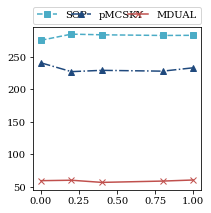

In [39]:
graphdf_nochange = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']==0) & \
        (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
graphdf_change = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0) & \
        (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
graphdf = pd.concat([graphdf_nochange,graphdf_change])

graphdf = graphdf[target_alg_stationarity]
fig = plt.figure(figsize=figsize_stationarity)
ax = fig.add_subplot(1,1,1)
plots = []
for i, algname in enumerate(target_alg_stationarity):
    plot = ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    plots += plot
# legend = ax.legend(handles=plots,labels=target_alg_stationarity)

legend = ax.legend(handles=plots,labels=target_alg_stationarity,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_stationarity), mode="expand", borderaxespad=0.)

In [47]:
figsize = (5, 0.2)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes

legend=ax_leg.legend(handles=plots,labels=target_alg_stationarity, loc='center', ncol=len(target_alg_stationarity), \
                facecolor='white', framealpha=1, edgecolor='black', fancybox = False, handlelength = 5,\
               prop={'size':8}, columnspacing=2
                     )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
legend.get_frame().set_linewidth(0.5)
fig_leg.savefig("Figures/"+'Stationarity_Legend.pdf', bbox_inches='tight', format='pdf')



# Varying Parameters

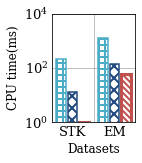

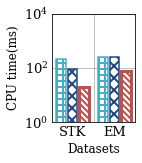

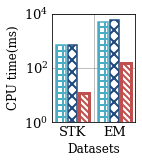

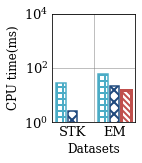

In [21]:
df = preprocessing_params('result_varyingParams')
df.to_excel(os.getcwd()+"/Metadata/result_varyingParams.xlsx")
dataset_vp = ["STK","EM"]

bargraph_Params(df=df, dataset=dataset_vp, metric="Time", \
                FONTSIZE_XLABEL=FONTSIZE_XLABEL_vp, FONTSIZE_YLABEL=FONTSIZE_YLABEL_vp,\
                FONTSIZE_XTICK=FONTSIZE_XTICK_vp, FONTSIZE_YTICK=FONTSIZE_YTICK_vp, ytickList=[1,1e2,1e4])

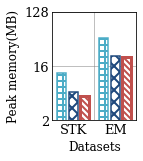

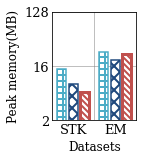

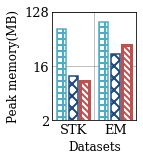

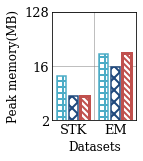

In [22]:
bargraph_Params(df=df, dataset=dataset_vp, metric="PeakMem", \
                FONTSIZE_XLABEL=FONTSIZE_XLABEL_vp, FONTSIZE_YLABEL=FONTSIZE_YLABEL_vp,\
                FONTSIZE_XTICK=FONTSIZE_XTICK_vp, FONTSIZE_YTICK=FONTSIZE_YTICK_vp, ytickList=[2,2**4,2**7])

## Varying Param Legend

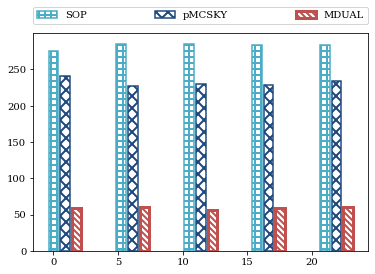

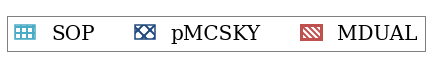

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i, algname in enumerate(target_alg_vp):
    xposition = np.arange(graphdf.shape[0])*barWidth*(graphdf.shape[0]+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
               linewidth=algo_linewidth[algname], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=target_alg_vp,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_others), mode="expand", borderaxespad=0.)

figsize = (7, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes

legend = ax_leg.legend(handles=bars,labels=target_alg_vp, loc='center', ncol=len(target_alg_stationarity), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =1,\
               prop={'size':20})
# hide the axes frame and the x/y labels
legend.get_frame().set_linewidth(0.5)
ax_leg.axis('off')
fig_leg.savefig("Figures/"+'VaryingParam_Legend.pdf', bbox_inches='tight', format='pdf')

# Complexity Analysis





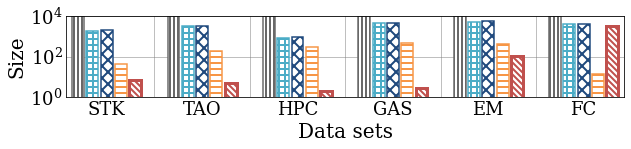

In [24]:
cx_colormap = ['dimgrey','#4BACC6','#1F497D','#F79646','#C0504D']
cx_params_time = [r"$N_W$", r"$N_{sky}^{sop}$", r"$N_{sky}^{pmcsky}$", r"$N_G$", r"$N_C/N_G$"]
cx_params_space = [r"$N_W$", r"$N_{sky}^{sop}$", r"$N_{sky}^{pmcsky}$", r"$N_G$", r"$N_Q$"]

cx_hatch = list(algo_hatch.values())[0:4] + [list(algo_hatch.values())[5]]
cx_linewidth = list(algo_linewidth.values())[0:4] + [list(algo_linewidth.values())[5]]


df_time = pd.read_csv("Data/results_time_complexity.csv",sep='\t')
df_time = df_time.set_index('Dataset')
df_time = df_time.T

fig = plt.figure(figsize=figsize_cx)
ax = fig.add_subplot(1,1,1)

xpositions=[]
for i in range(len(df_time)):
    xposition = np.arange(df_time.shape[1])*barWidth*(len(dataset)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,df_time.iloc[i,:].tolist(), color = "white", width=barWidth,\
               hatch=cx_hatch[i], edgecolor=cx_colormap[i],\
               linewidth=cx_linewidth[i], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL_cx)
ax.set_ylabel('Size', fontsize=FONTSIZE_YLABEL_cx)

ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([1,10000])
plt.yticks([1,1e2,1e4])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)


# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK_cx) # pad=15
ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK_cx)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig("Figures/"+'Complexity_Time.pdf', bbox_inches='tight', format='pdf')

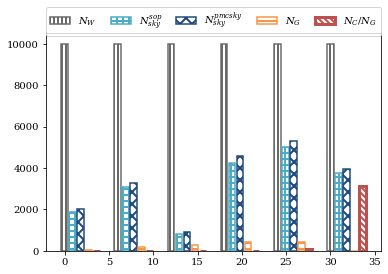

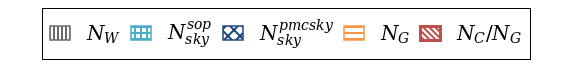

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i in range(len(df_time)):
    xposition = np.arange(df_time.shape[1])*barWidth*(len(dataset)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,df_time.iloc[i,:].tolist(), color = "white", width=barWidth,\
               hatch=cx_hatch[i], edgecolor=cx_colormap[i],\
               linewidth=cx_linewidth[i], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=cx_params_time,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(cx_params_time), mode="expand", borderaxespad=0.)

figsize = (10, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(handles=bars,labels=cx_params_time, loc='center', ncol=len(cx_params_time), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False, handlelength =1,\
              prop={'size':20}, columnspacing=0.5
              )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig("Figures/"+'Complexity_Time_Legend.pdf', bbox_inches='tight', format='pdf')

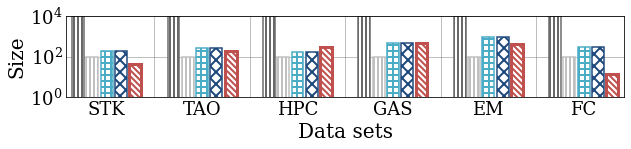

In [26]:
cx_colormap = ['dimgrey','silver','#4BACC6','#1F497D','#C0504D']
cx_colormap_fill = ['grey','white','white','white','white']
cx_params_space = [r"$N_W$", r"$N_Q$", r"$M_{sky}^{sop}$", r"$M_{sky}^{pmcsky}$", r"$N_G$"]

cx_hatch_ = list(algo_hatch.values())[0:4] + [list(algo_hatch.values())[5]]
cx_hatch[1] = cx_hatch_[0]
cx_hatch[2] = cx_hatch_[1]
cx_hatch[3] = cx_hatch_[2]
cx_linewidth = list(algo_linewidth.values())[0:4] + [list(algo_linewidth.values())[5]]


df_time = pd.read_csv("Data/results_space_complexity.csv",sep='\t')
df_time = df_time.set_index('Dataset')
df_time = df_time.T

fig = plt.figure(figsize=figsize_cx)
ax = fig.add_subplot(1,1,1)

xpositions=[]
for i in range(len(df_time)):
    xposition = np.arange(df_time.shape[1])*barWidth*(len(dataset)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,df_time.iloc[i,:].tolist(), color = "white", width=barWidth,\
               hatch=cx_hatch[i], edgecolor=cx_colormap[i],\
               linewidth=cx_linewidth[i], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL_cx)
ax.set_ylabel('Size', fontsize=FONTSIZE_YLABEL_cx)

ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([1,10000])
plt.yticks([1,1e2,1e4])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)


# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK_cx) # pad=15
ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK_cx)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig("Figures/"+'Complexity_Space.pdf', bbox_inches='tight', format='pdf')

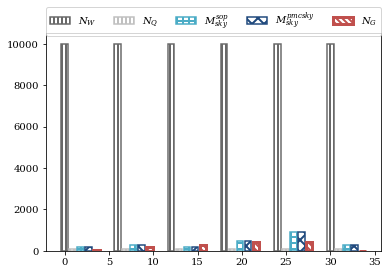

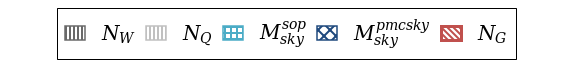

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i in range(len(df_time)):
    xposition = np.arange(df_time.shape[1])*barWidth*(len(dataset)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,df_time.iloc[i,:].tolist(), color = "white", width=barWidth,\
               hatch=cx_hatch[i], edgecolor=cx_colormap[i],\
               linewidth=cx_linewidth[i], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=cx_params_space,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(cx_params_space), mode="expand", borderaxespad=0.)

figsize = (10, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(handles=bars,labels=cx_params_space, loc='center', ncol=len(cx_params_space), \
                facecolor='white', framealpha=1, edgecolor='black', fancybox = False, handlelength =1,\
              prop={'size':20}, columnspacing=0.5
              )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig("Figures/"+'Complexity_Space_Legend.pdf', bbox_inches='tight', format='pdf')

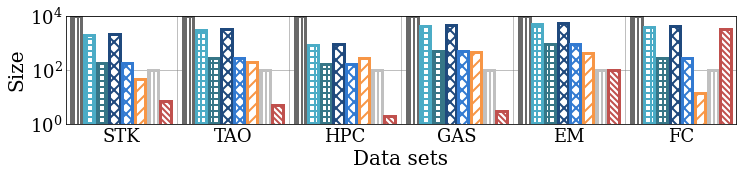

In [28]:
figsize_cx = (12,2)
FONTSIZE_XTICK_cx=18
FONTSIZE_YTICK_cx=18
FONTSIZE_XLABEL_cx=20
FONTSIZE_YLABEL_cx=20
barWidth_cx = 0.3
intra_bar_space_cx = 0.5
inter_bar_space_cx = 5

cx_colormap = ['dimgrey','#4BACC6','#367687','#1F497D','#327ad1','#F79646','silver','#C0504D']
cx_params = [r"$N_D$", r"$N^{sop}$", r"$M^{sop}$", r"$N^{pmcsky}$",\
             r"$M^{pmcsky}$", r"$N_G$", r"$N_Q$", r"$N_C/N_G$"]

# (N_W -> Nsky -> Msky ->N_G ->N_Q -> N_C/N_G
cx_hatch = [list(algo_hatch.values())[0],list(algo_hatch.values())[1],list(algo_hatch.values())[1],list(algo_hatch.values())[2],\
            list(algo_hatch.values())[2],list(algo_hatch.values())[4],list(algo_hatch.values())[0],list(algo_hatch.values())[5]]
cx_linewidth = list(algo_linewidth.values())[0:4] + [list(algo_linewidth.values())[5]]


df_time = pd.read_csv("Data/results_time_complexity.csv",sep='\t')
df_time = df_time.set_index('Dataset')
df_time = df_time.T

df_space = pd.read_csv("Data/results_space_complexity.csv",sep='\t')
df_space = df_space.set_index('Dataset')
df_space = df_space.T

df = pd.concat([df_time,df_space])
df = df.drop_duplicates()
df = df.reindex(["NW","N_{sky}^{sop}", "M_{sky}^{sop}", "N_{sky}^{pmcsky}","M_{sky}^{pmcsky}",\
    "N_G","N_Q","N_C/N_G"])

fig = plt.figure(figsize=figsize_cx)
ax = fig.add_subplot(1,1,1)

xpositions=[]
for i in range(len(df)):
    xposition = np.arange(df.shape[1])*barWidth_cx*(len(dataset)+inter_bar_space_cx) + barWidth*intra_bar_space_cx*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,df.iloc[i,:].tolist(), color = "white", width=barWidth_cx,\
               hatch=cx_hatch[i], edgecolor=cx_colormap[i],\
               linewidth=3, zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL_cx)
ax.set_ylabel('Size', fontsize=FONTSIZE_YLABEL_cx)

ax.set_xlim([-barWidth_cx,xposition[-1]+barWidth_cx])
ax.set_ylim([1,10000])
plt.yticks([1,1e2,1e4])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)


# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK_cx) # pad=15
ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK_cx)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig("Figures/"+'Complexity_Overall.pdf', bbox_inches='tight', format='pdf')

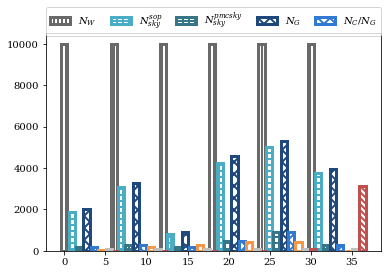

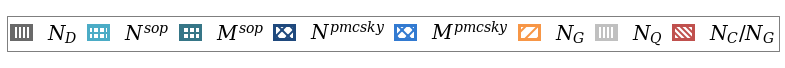

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i in range(len(df)):
    xposition = np.arange(df.shape[1])*barWidth*(len(dataset)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,df.iloc[i,:].tolist(), color = "white", width=barWidth,\
               hatch=cx_hatch[i], edgecolor=cx_colormap[i],\
               linewidth=3, zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=cx_params_time,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(cx_params_time), mode="expand", borderaxespad=0.)

figsize = (10,1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
legend = ax_leg.legend(handles=bars,labels=cx_params, loc='center', ncol=len(cx_params), \
                facecolor='white', framealpha=1, edgecolor='black', fancybox = False, handlelength =1,\
              prop={'size':20}, columnspacing=0.5, borderpad=0.2
              )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
legend.get_frame().set_linewidth(0.5)
fig_leg.savefig("Figures/"+'Complexity_Overall_Legend.pdf', bbox_inches='tight', format='pdf')


In [30]:
# def preprocessing_dist(path):
#     headerf = open("Data/"+path+".txt")
#     header = headerf.readline()
#     header = "\t".join(header.split())
#     w=open(os.getcwd()+"/Metadata/"+path+"_separated.csv",'w')
#     w.write(header+"\tparamKey"+"\n")
#
#     f=open("Data/"+path+".txt",'r')
#     i = -1
#     for line in f.readlines():
#         i += 1
#         if (i<2):
#             continue
#         if 'Mu: ' in line:
#             split_line = line.split(sep=" ")
#             param_key = split_line[-1]
#             continue
#         line = line.replace("OURS",alg_name)
#         line += "\t" + param_key
#         tab_sep_line = "\t".join(line.split())
#         w.write(tab_sep_line+"\n")
#     w.close()
#     dataframe = pd.read_csv(os.getcwd()+"/Metadata/"+path+"_separated.csv", sep="\t")
#     dataframe = dataframe.groupby(["Dataset","Queryset","ChgQRatio","Method","paramKey"]).mean()
#     dataframe.reset_index(inplace=True)
#     return dataframe
#
# figsize_di = (1.5,2)
# target_alg_di = ['SOP','pMCSKY',alg_name]
# FONTSIZE_XTICK_di=13
# FONTSIZE_YTICK_di=13
# FONTSIZE_XLABEL_di=12
# FONTSIZE_YLABEL_di=12
# dataset_di = ["STK","TAO","HPC","GAS","EM","FC"]
#
# # uniform distribution
#
# df = preprocessing_dist("result_uniform")
#
# x = [0,0.2] # should be changed when 20 has come in
# for dataname in dataset_di:
#     graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="paramKey",columns="Method",values="Time")
#
#     graphdf = graphdf[target_alg_di]
#     fig = plt.figure(figsize=figsize_di)
#     ax = fig.add_subplot(1,1,1)
#     for i, algname in enumerate(target_alg_di):
#         ax.plot(x, graphdf[algname].tolist(), linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
#     ax.grid(b=True,which="major",axis='y',zorder=0)
#     ax.set_xlabel("Mean of distribution", fontsize=FONTSIZE_XLABEL_di)
#     ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_di)
#     ax.set_xlim([-0.1,0.5])
#     ax.set_yscale("log")
#     ax.tick_params(axis='both', which ='both', length = 0)
#     ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_di)
#     ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_di)
#     plt.xticks(x)
#     ax.set_xticklabels([5,10,20])
#     plt.yticks([1e1,1e3,1e5])
#     ax.tick_params(axis ='x', rotation = 0)
#
#     plt.savefig("Figures/"+'Uniform_'+dataname+'_CpuTime.pdf', bbox_inches='tight', format='pdf')
#
# for dataname in dataset_di:
#     graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="paramKey",columns="Method",values="PeakMem")
#     graphdf = graphdf[target_alg_di]
#     fig = plt.figure(figsize=figsize_di)
#     ax = fig.add_subplot(1,1,1)
#     for i, algname in enumerate(target_alg_di):
#         ax.plot(x,graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
#     ax.grid(b=True,which="major",axis='y',zorder=0)
#     ax.set_xlabel("Mean of distribution", fontsize=FONTSIZE_XLABEL_di)
#     ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_di)
#     ax.set_xlim([-0.1,0.5])
#     ax.set_yscale("log",basey=2)
#     ax.tick_params(axis='both', which ='both', length = 0)
#     ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_di)
#     ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_di)
#
#     ax.tick_params(axis ='x', rotation = 0)
#     plt.xticks(x)
#     ax.set_xticklabels([5,10,20])
#     plt.yticks([1,32,1024])
#     ax.set_yticklabels(["1","32","1024"])
#     ax.tick_params(axis ='x', rotation = 0)
#
#     plt.savefig("Figures/"+'Uniform_'+dataname+'_PeakMem.pdf', bbox_inches='tight', format='pdf')



# Scatter plot

In [31]:
def preprocessing_dist_scatter(path, distname):
    headerf = open("Data/"+path+".txt")
    header = headerf.readline()
    header = "\t".join(header.split())
    w=open(os.getcwd()+"/Metadata/"+path+"_separated.csv",'w')
    w.write(header+"\tparamKey"+"\n")

    f=open("Data/"+path+".txt",'r')
    i = -1
    for line in f.readlines():
        i += 1
        if (i<2):
            continue
        if 'Mu: ' in line:
            split_line = line.split(sep=" ")
            param_key = split_line[-1]
            continue
        line = line.replace("OURS",alg_name)
        line += "\t" + distname + "(" + param_key.strip() + ")"
        tab_sep_line = "\t".join(line.split())
        w.write(tab_sep_line+"\n")
    w.close()
    dataframe = pd.read_csv(os.getcwd()+"/Metadata/"+path+"_separated.csv", sep="\t")
    dataframe = dataframe.groupby(["Dataset","Queryset","ChgQRatio","Method","paramKey"]).mean()
    dataframe.reset_index(inplace=True)
    return dataframe

In [32]:
df_u=preprocessing_dist_scatter("result_uniform","uniform")
df_g=preprocessing_dist_scatter("result_gaussian","gaussian")
df_e=preprocessing_dist_scatter("result_exponential","exponential")
df = pd.concat([df_u,df_g,df_e])
df.to_excel(os.getcwd()+"/Metadata/result_distribution.xlsx")
# df=preprocessing_dist_scatter("result_gaussian","gaussian")


In [33]:
dist_list = ['uniform(5)','uniform(10)','uniform(20)','gaussian(2)','gaussian(4)','gaussian(8)','exponential(2)','exponential(4)','exponential(8)']
# dist_color = {'uniform(5)': "#bbfcc0",'uniform(10)': "#63ff6f",'uniform(20)': "#00ff14",\
#                 'gaussian(2)': "#e6b3ff", 'gaussian(4)': "#ce6bff",'gaussian(8)': "#aa00ff",\
#                 'exponential(2)': "#ffccf3", 'exponential(4)':"#ff75df", 'exponential(8)': "#fa00c0"}
dist_color = {'uniform(5)': "red",'uniform(10)': "red",'uniform(20)': "red",\
                'gaussian(2)': "green", 'gaussian(4)': "green",'gaussian(8)': "green",\
                'exponential(2)': "blue", 'exponential(4)':"blue", 'exponential(8)': "blue"}



figsize_di = (3,3)
target_alg_di = ['SOP','pMCSKY',alg_name]
FONTSIZE_XTICK_di=18
FONTSIZE_YTICK_di=18
FONTSIZE_XLABEL_di=20
FONTSIZE_YLABEL_di=20
# dataset_di = ["STK"]
dataset_di = ["STK","TAO","HPC","GAS","EM","FC"]


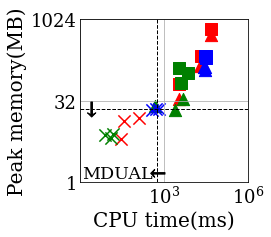

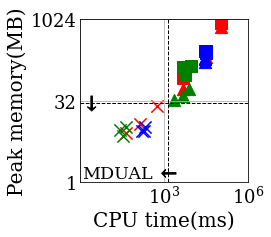

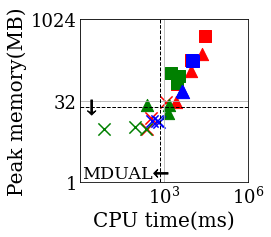

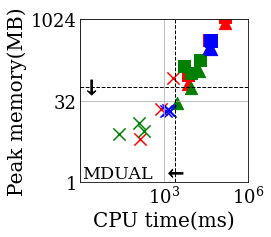

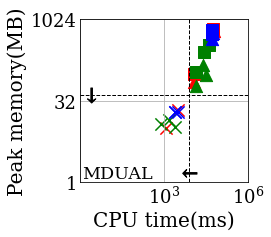

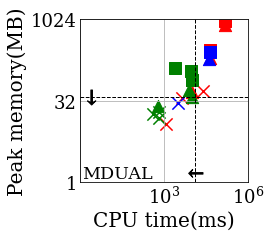

In [34]:
for dataname in dataset_di:
    graphdf = df.loc[(df["Dataset"]==dataname)]
    fig = plt.figure(figsize=figsize_di)
    ax = fig.add_subplot(1,1,1)
    for ind,row in graphdf.iterrows():
        # print(row["paramKey"],row["Time"])
        dist = row["paramKey"]
        mu = int(dist[-2])
        algname = row["Method"]
        ax.scatter(row["Time"], row["PeakMem"], s=150,marker=algo_marker[algname], color=dist_color[dist])

    max_time_ours = graphdf.loc[(graphdf["Method"]==alg_name)]["Time"].max()
    max_memory_ours  = graphdf.loc[(graphdf["Method"]==alg_name)]["PeakMem"].max()

    min_time_others = graphdf.loc[(graphdf["Method"]=="SOP") | (graphdf["Method"]=="pMCSKY")]["Time"].min()
    min_memory_others = graphdf.loc[(graphdf["Method"]=="SOP") | (graphdf["Method"]=="pMCSKY")]["PeakMem"].min()

    boundary_time = (max_time_ours + min_time_others)/2
    boundary_memory = (max_memory_ours + min_memory_others)/2

    plt.axvline(x=boundary_time, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=boundary_memory, color='black', linewidth=1, linestyle='--')

    # ax_arrow = plt.axes()
    # ax.arrow(boundary_time,2,-boundary_time*0.9, 0, head_width=1, head_length=50,\
    #          length_includes_head=False,lw=1,color="black") # horizontal arrow
    # ax.hline(boundary_time,2,-boundary_time*0.9, 0, head_width=1, head_length=50,\
    #              length_includes_head=False,lw=1,color="black")
    plt.plot(boundary_time,np.sqrt(2), 'ko', marker=r'$\leftarrow$', markersize=15)
    plt.plot(2, boundary_memory, 'ko', marker=r'$\downarrow$', markersize=15)
    # plt.annotate('', xy=(boundary_time,2), xytext=(2, 0.002),
    #             arrowprops=dict(facecolor='black', shrink=0.),
    #             )
    ax.text(1.2, 1.2, alg_name, fontsize=FONTSIZE_XTICK_di-0.5)

    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.grid(b=True,which="major",axis='x',zorder=0)
    ax.set_xlabel("CPU time(ms)", fontsize=FONTSIZE_XLABEL_di)
    ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_di)

    ax.set_xscale("log",basex=10)
    ax.set_yscale("log",basey=2)
    ax.tick_params(axis='both', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_di)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_di)
    plt.xticks([1,1e3,1e6])
    ax.set_xticklabels(["","$10^3$","$10^6$"])
    ax.set_xlim([1,1000000])
    ax.set_ylim([1,1024])

    plt.yticks([1,32,1024])
    ax.set_yticklabels([1,32,1024])
    ax.tick_params(axis ='x', rotation = 0)

    plt.savefig("Figures/"+'Distribution_'+dataname+'_Scatter.pdf', bbox_inches='tight', format='pdf')

In [35]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# xpositions = []
# dots = []
#
# for distname in ['uniform(5)','gaussian(2)','exponential(2)']:
#     dot = ax.scatter(1, 1, marker='o', color=dist_color[distname])
#     dots.append(dot)
#
#
# figsize = (5, 1)
# fig_leg = plt.figure(figsize=figsize)
# ax_leg = fig_leg.add_subplot(111)
# ax_leg.legend(handles=dots,labels=['Uniform','Gaussian','Exponential'], loc='center', ncol=3, \
#                 facecolor='white', framealpha=1,edgecolor='black', fancybox = False, handlelength =1,\
#               prop={'size':10}, columnspacing=0.5
#               )
#
# ax_leg.axis('off')
# fig_leg.savefig("Figures/"+'Distribution_Legend_Dist.pdf', bbox_inches='tight', format='pdf')

In [36]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# xpositions = []
# dots = []
#
# for algname in target_alg_di:
#     dot = ax.scatter(1, 1, marker = algo_marker[algname], color="black")
#     dots.append(dot)
#
# figsize = (5, 1)
# fig_leg = plt.figure(figsize=figsize)
# ax_leg = fig_leg.add_subplot(111)
# ax_leg.legend(handles=dots,labels=target_alg_di, loc='center', ncol=len(target_alg_di), \
#                 facecolor='white', framealpha=1,edgecolor='black', fancybox = False, handlelength =1,\
#               prop={'size':10}, columnspacing=0.5
#               )
#
# ax_leg.axis('off')
# fig_leg.savefig("Figures/"+'Distribution_Legend_Alg.pdf', bbox_inches='tight', format='pdf')

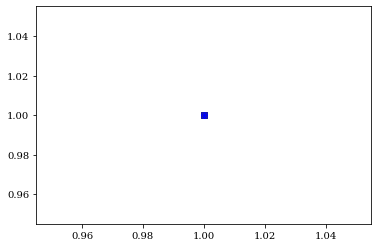

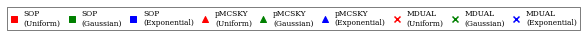

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
dots = []
labels = []

for algname in target_alg_di:
    for distname in ['uniform(5)','gaussian(2)','exponential(2)']:
        distName = distname[:-3]
        distName = distName.capitalize()
        labels.append(algname + "\n(" + distName +")")
        dot = ax.scatter(1, 1, marker = algo_marker[algname], color=dist_color[distname])
        dots.append(dot)

figsize = (10, 0.4)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
legend = ax_leg.legend(handles=dots,labels=labels, loc='center', ncol=len(labels), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False, handlelength =1,\
              prop={'size':7.5}, columnspacing=1
              )

ax_leg.axis('off')
legend.get_frame().set_linewidth(0.5)
fig_leg.savefig("Figures/"+'Distribution_Legend.pdf', bbox_inches='tight', format='pdf')

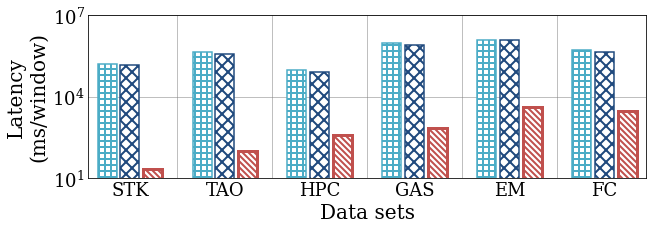

In [9]:
df = preprocessing("result_throughput_latency")

df.to_excel(os.getcwd()+"/Metadata/result_throughput_latency.xlsx")

dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="Time")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time")])

graphdf = graphdf[target_alg_others]


graphdf = graphdf.reindex(index=dataset)
fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_others):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_others)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL)
ax.set_ylabel('Latency\n(ms/window)', fontsize=FONTSIZE_YLABEL)

ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([10,10000000])
plt.yticks([10,1e4,1e7])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)


# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK) # pad=15
ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig("Figures/"+'Overall_Latency.pdf', bbox_inches='tight', format='pdf')

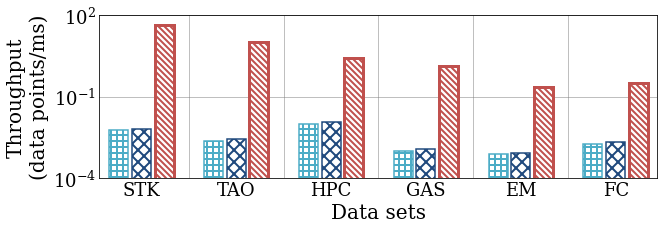

In [10]:
fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_others):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_others)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,(1000/graphdf.iloc[:,i]).tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL)
ax.set_ylabel('Throughput\n(data points/ms)', fontsize=FONTSIZE_YLABEL)

ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([0.0001,100])
plt.yticks([0.0001,0.1,100])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)


# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK) # pad=15
ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig("Figures/"+'Overall_Throughput.pdf', bbox_inches='tight', format='pdf')